# Joint single-cell mitochondrial DNA genotyping and DNA accessibility analysis
### Jonathan Levine


Here, we take a look at smack analzying variants from the mtscATAC  dataset from https://www.nature.com/articles/s41587-020-0645-6#Fig3

In [40]:
import numpy as np
import pandas as pd
import os
import sys
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn3

#### Load Data
This data is filtered using 2 different strategies: 
###### 1. The 6hr data and the 1hr data are filtered separately and then combined after variant calling and filtering 
###### 2.  The two datasets are combined and variants are filtered in a joint matrix with joint statistics

In [41]:
hr6_dir = "tf1_mtscatac_separate_TF1-MERFF_hr6"
hr1_dir = "tf1_mtscatac_separate_TF1-MERFF_hr1"
combined_dir = "tf1_combined_mtscatac_all"

In [42]:
initial_filter_cols = ['pass_strand_correlation', 'pass_vmr', 'pass_homoplasmic', 'pass_ncells', 'pass_coverage','pass_ks_test']

In [43]:
hr6_coverage = pd.read_csv(os.path.join(hr6_dir,'temp/all_variants_coverage.csv'),index_col='variant')
hr1_coverage = pd.read_csv(os.path.join(hr1_dir,'temp/all_variants_coverage.csv'),index_col='variant')
combined_coverage = pd.read_csv(os.path.join(combined_dir,'temp/all_variants_coverage.csv'),index_col='variant')

In [44]:
hr1_df = pd.read_csv(os.path.join(hr1_dir,'temp/all_variants_statistics.csv'),index_col='variant')

hr1_df['mean_coverage'] = hr1_coverage.apply(np.mean,axis=1).loc[hr1_df.index]
hr1_df['pass_strand_correlation'] = hr1_df['strand_correlation'].apply(lambda s: s>=.65)
hr1_df['pass_coverage'] = hr1_df['mean_coverage'].apply(lambda c: c>10)
hr1_df['pass_ncells'] = hr1_df['n_cells_over_5'].apply(lambda c: c>=3)
hr1_df['pass_vmr'] = hr1_df['vmr'].apply(lambda c: np.log10(c)>= -2)
hr1_df['pass_homoplasmic'] = hr1_df['mean'].apply(lambda c: c <= 0.95)
hr1_df['pass_ks_test'] = hr1_df['alt_ref_statistic'].apply(lambda c: c <= 0.35)
hr1_df['pass_initial_filters'] = hr1_df.apply(
        lambda row: all(row[col] for col in initial_filter_cols), axis=1
)

hr6_df = pd.read_csv(os.path.join(hr6_dir,'temp/all_variants_statistics.csv'),index_col='variant')

hr6_df['mean_coverage'] = hr6_coverage.apply(np.mean,axis=1).loc[hr6_df.index]
hr6_df['pass_strand_correlation'] = hr6_df['strand_correlation'].apply(lambda s: s>=.65)
hr6_df['pass_coverage'] = hr6_df['mean_coverage'].apply(lambda c: c>10)
hr6_df['pass_ncells'] = hr6_df['n_cells_over_5'].apply(lambda c: c>=3)
hr6_df['pass_vmr'] = hr6_df['vmr'].apply(lambda c: np.log10(c)>= -2)
hr6_df['pass_homoplasmic'] = hr6_df['mean'].apply(lambda c: c <= 0.95)
hr6_df['pass_ks_test'] = hr6_df['alt_ref_statistic'].apply(lambda c: c <= 0.35)
hr6_df['pass_initial_filters'] = hr6_df.apply(
        lambda row: all(row[col] for col in initial_filter_cols), axis=1
)


combined_df = pd.read_csv(os.path.join(combined_dir,'temp/all_variants_statistics.csv'),index_col='variant')

combined_df['mean_coverage'] = combined_coverage.apply(np.mean,axis=1).loc[combined_df.index]
combined_df['pass_strand_correlation'] = combined_df['strand_correlation'].apply(lambda s: s>=.65)
combined_df['pass_coverage'] = combined_df['mean_coverage'].apply(lambda c: c>10)
combined_df['pass_ncells'] = combined_df['n_cells_over_5'].apply(lambda c: c>=3)
combined_df['pass_vmr'] = combined_df['vmr'].apply(lambda c: np.log10(c)>= -2)
combined_df['pass_homoplasmic'] = combined_df['mean'].apply(lambda c: c <= 0.95)
combined_df['pass_ks_test'] = combined_df['alt_ref_statistic'].apply(lambda c: c <= 0.35)
combined_df['pass_initial_filters'] = combined_df.apply(
        lambda row: all(row[col] for col in initial_filter_cols), axis=1
)


In [45]:
unioned_variants = set(hr6_df[hr6_df['pass_initial_filters']].index).union(set(hr1_df[hr1_df['pass_initial_filters']].index))


combined_variants = set(combined_df[combined_df['pass_initial_filters']].index)


Text(0.5, 1.0, 'TF1 & TF6 Unique Variants')

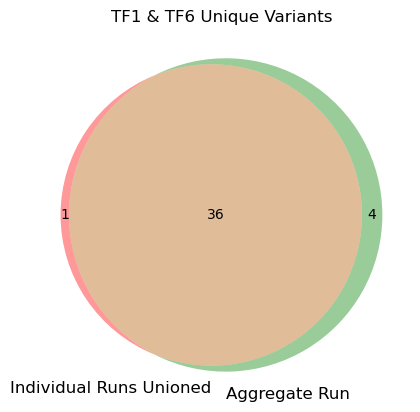

In [46]:
venn2([unioned_variants, combined_variants], ['Individual Runs Unioned', 'Aggregate Run'])
plt.title('TF1 & TF6 Unique Variants')

In [47]:
left = unioned_variants.difference(combined_variants)
center = unioned_variants.intersection(combined_variants)
right = combined_variants.difference(unioned_variants)

In [48]:
left_df = combined_df.loc[list(left)]
center_df = combined_df.loc[list(center)]
right_df = combined_df.loc[list(right)]

Text(0, 0.5, 'n cells over 5')

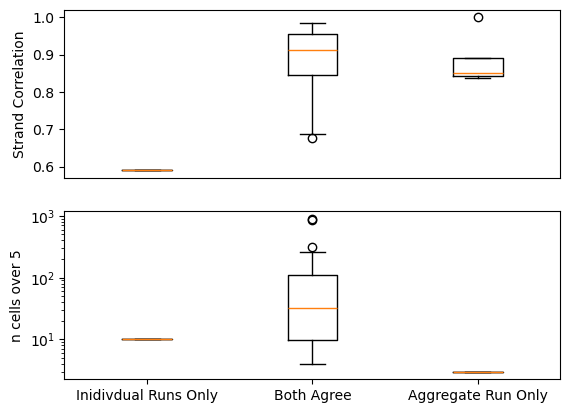

In [49]:
plt.figure()
plt.subplot(2,1,1)

l_c_r = [left_df, center_df, right_df]
labels = ['Inidivdual Runs Only', 'Both Agree', 'Aggregate Run Only']
plt.ylabel('Strand Correlation')
plt.boxplot([df['strand_correlation'] for df in l_c_r])
plt.xticks([])

plt.subplot(2,1,2)
plt.boxplot([df['n_cells_over_5'] for df in l_c_r], labels=labels)
plt.yscale('log')
plt.ylabel('n cells over 5')


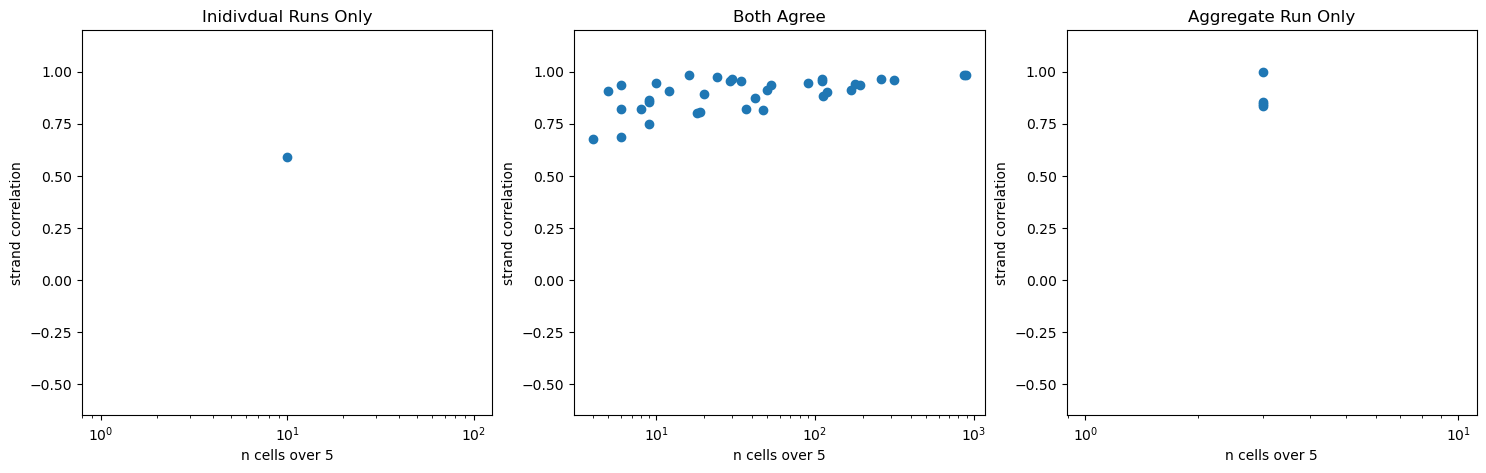

In [50]:
plt.figure(figsize=(18,5))
for i,df in enumerate(l_c_r):
    plt.subplot(1,3,i+1)
    plt.title(labels[i])
    plt.scatter(df['n_cells_over_5'],df['strand_correlation'])
    plt.xscale('log')
    plt.xlabel('n cells over 5')
    plt.ylabel('strand correlation')
    plt.ylim([-.65, 1.2])

In [51]:
for i,df in enumerate(l_c_r):
    print(labels[i])
    print(list(df[df['n_cells_over_5']>10**2].index))
    print("----")

Inidivdual Runs Only
[]
----
Both Agree
['4037_G_A', '10552_C_T', '10068_G_A', '7789_G_C', '1888_G_A', '627_G_A', '13708_G_A', '3901_G_A', '5790_C_T', '8002_C_T', '7316_G_A']
----
Aggregate Run Only
[]
----


In [52]:
full_matrix = pd.read_csv(os.path.join(combined_dir,'temp/all_variants_heteroplasmy_matrix.csv'),index_col='variant')
matrix = full_matrix.loc[list(combined_variants)]

In [53]:
matrix.head(5)

,TF1-MERFF_hr6_GTGGATTAGTTGCTTG-1,TF1-MERFF_hr1_ACATGCAGTTCTTTGT-1,TF1-MERFF_hr6_GCGAGTCGTGCGTTTA-1,TF1-MERFF_hr1_GCAGATTTCCATCGAA-1,TF1-MERFF_hr6_AGTGTACAGCGTATCT-1,TF1-MERFF_hr6_GGAATCTAGTGTCACT-1,TF1-MERFF_hr6_CTTGAAGAGACTCGGA-1,TF1-MERFF_hr1_TTTGGCCGTCCTCAGG-1,TF1-MERFF_hr1_TATCGAGGTGATGTGG-1,TF1-MERFF_hr1_GAGCGCTAGGAAGAAC-1,...,TF1-MERFF_hr6_GCGTAGCGTTGTCGGC-1,TF1-MERFF_hr1_TTGTTGTAGGAAGAAC-1,TF1-MERFF_hr6_TTATGTCTCGCTAGTA-1,TF1-MERFF_hr6_GTAATCGAGAACGACC-1,TF1-MERFF_hr6_TTGTCTATCAGTTGAC-1,TF1-MERFF_hr6_TGTGACAGTCACCGCA-1,TF1-MERFF_hr1_CACCACTGTTAACTCG-1,TF1-MERFF_hr1_ACTACGAAGAGACTCG-1,TF1-MERFF_hr6_TTGCTTACAACGACAG-1,TF1-MERFF_hr1_TAGCATGAGCGTGTTT-1
variant,,,,,,,,,,,,,,,,,,,,,
14569_G_A,0.000000,0.002703,0.000000,0.000000,0.0,0.007168,0.0,0.000000,0.000000,0.0,...,0.000000,0.060870,0.000000,0.000000,0.04811,0.000000,0.000000,0.000000,0.000000,0.000000
12433_C_T,0.013453,0.000000,0.000000,0.019231,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4037_G_A,0.000000,0.112820,0.221154,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.181817,0.046025,0.000000,0.027132,0.07971,0.181818,0.000000,0.045455,0.076923,0.168627
10552_C_T,0.000000,0.025070,0.000000,0.000000,0.0,0.125000,0.0,0.083916,0.074074,0.0,...,0.000000,0.000000,0.061452,0.065041,0.00000,0.000000,0.022472,0.000000,0.000000,0.000000
10068_G_A,0.000000,0.021407,0.061403,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.050909


Text(0.5, 0.98, 'Combined TF1 & TF6 Variants')

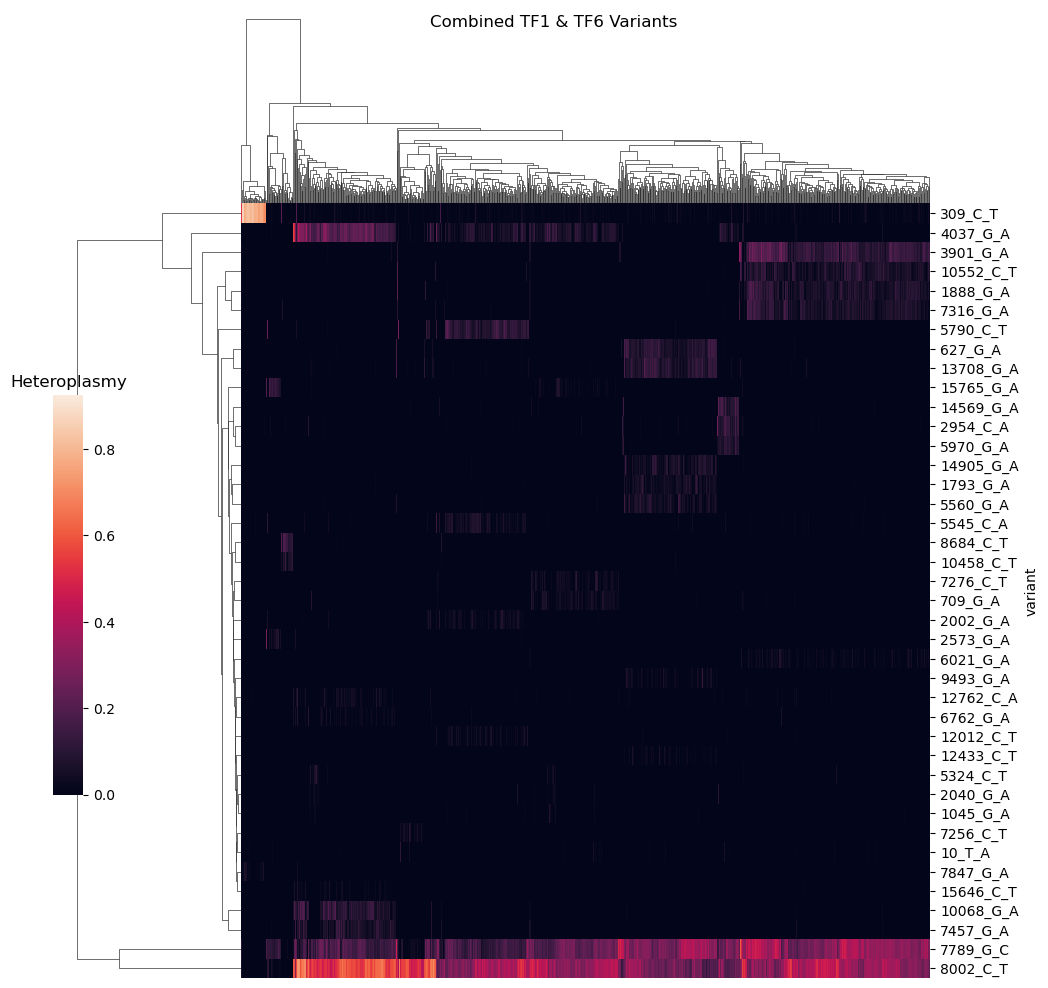

In [54]:
sns.clustermap(matrix,xticklabels=False,cbar_pos=(0, .2, .03, .4),dendrogram_ratio=.2,yticklabels=True)
plt.title('Heteroplasmy')
plt.suptitle('Combined TF1 & TF6 Variants')

Text(0.5, 0.98, 'Combined TF1 & TF6 Variants')

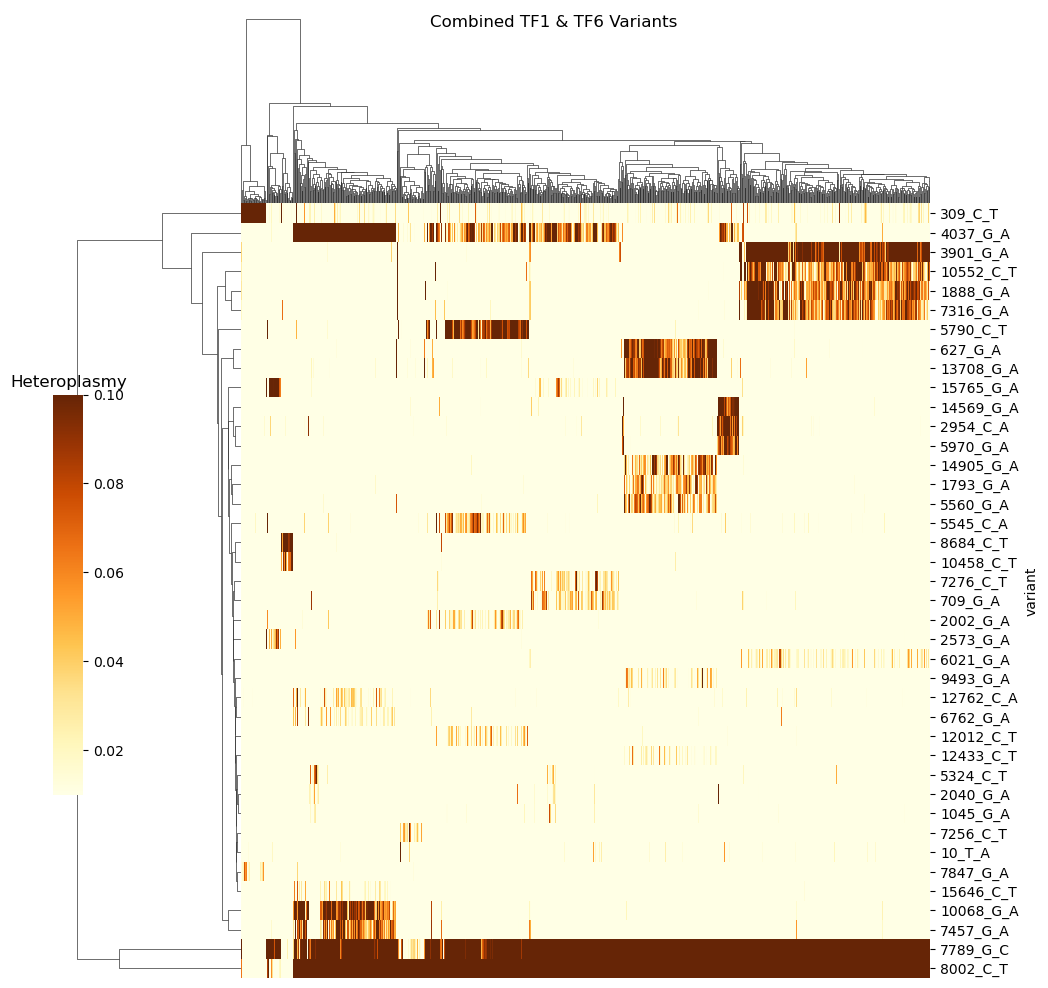

In [55]:
sns.clustermap(matrix,xticklabels=False,cbar_pos=(0, .2, .03, .4),dendrogram_ratio=.2,yticklabels=True,
               vmin=.01, vmax=.1,cmap=sns.color_palette("YlOrBr", as_cmap=True))
plt.title('Heteroplasmy')
plt.suptitle('Combined TF1 & TF6 Variants')

In [56]:
mgatk_variants = pd.read_csv('TF1_VMR_processed_variants_ndetect.tsv',header=None)

In [57]:
def map_variant(v):
    split_idx = v.index(">")
    return f"{v[:split_idx-1]}_{v[split_idx-1]}_{v[split_idx+1:]}"
mgatk_variants['variant'] = mgatk_variants[mgatk_variants.columns[0]].apply(map_variant)
mgatk_variants.head(5)

,0,variant
0,8002C>T,8002_C_T
1,7789G>C,7789_G_C
2,8684C>T,8684_C_T
3,15765G>A,15765_G_A
4,5970G>A,5970_G_A


In [58]:
mgatk_variants_set = set(mgatk_variants['variant'])

Text(0.5, 1.0, 'TF1 & TF6 Unique Variants')

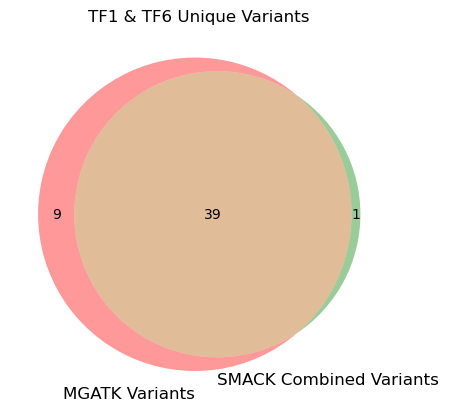

In [59]:
venn2([mgatk_variants_set, combined_variants], ['MGATK Variants', 'SMACK Combined Variants'])
plt.title('TF1 & TF6 Unique Variants')

In [60]:
left = mgatk_variants_set.difference(combined_variants)
center = mgatk_variants_set.intersection(combined_variants)
right = combined_variants.difference(mgatk_variants_set)

In [61]:
left_df = combined_df.loc[list(left)]
center_df = combined_df.loc[list(center)]
right_df = combined_df.loc[list(right)]

Text(0, 0.5, 'n cells over 5')

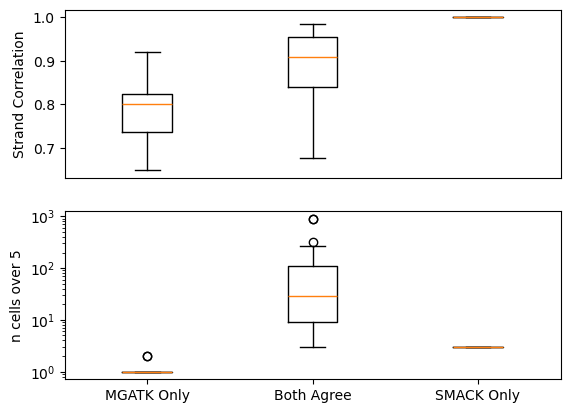

In [62]:
plt.figure()
plt.subplot(2,1,1)

l_c_r = [left_df, center_df, right_df]
labels = ['MGATK Only', 'Both Agree', 'SMACK Only']
plt.ylabel('Strand Correlation')
plt.boxplot([df['strand_correlation'] for df in l_c_r])
plt.xticks([])

plt.subplot(2,1,2)
plt.boxplot([df['n_cells_over_5'] for df in l_c_r], labels=labels)
plt.yscale('log')
plt.ylabel('n cells over 5')

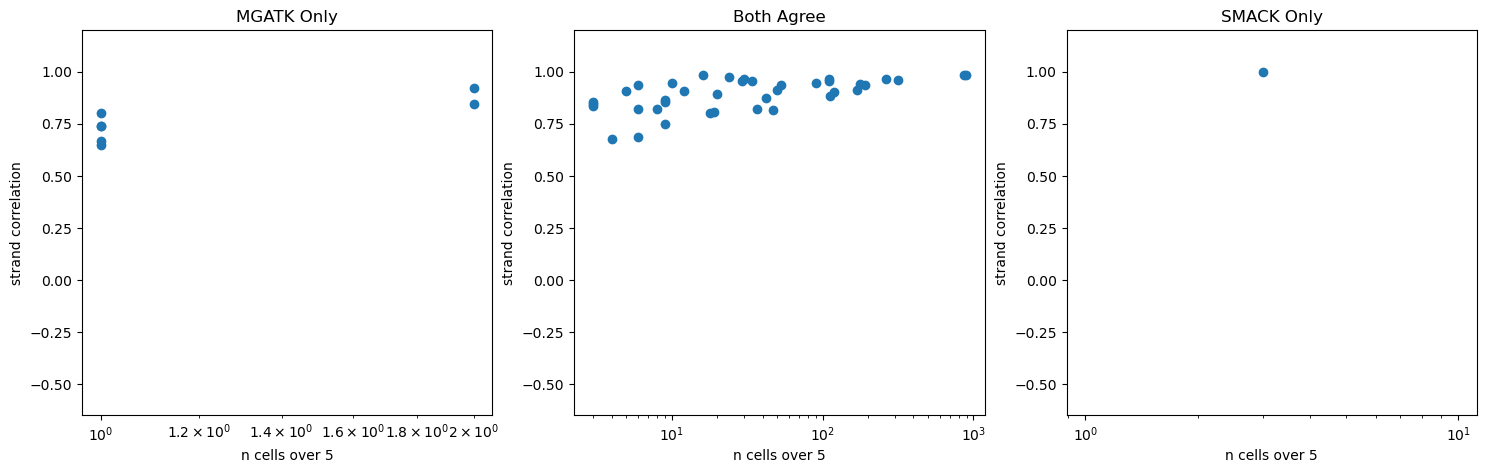

In [63]:
plt.figure(figsize=(18,5))
for i,df in enumerate(l_c_r):
    plt.subplot(1,3,i+1)
    plt.title(labels[i])
    plt.scatter(df['n_cells_over_5'],df['strand_correlation'])
    plt.xscale('log')
    plt.xlabel('n cells over 5')
    plt.ylabel('strand correlation')
    plt.ylim([-.65, 1.2])

In [64]:
combined_df.loc[list(left)]

,strand_correlation,variance,vmr,alt_ref_statistic,alt_uniform_statistic,ref_uniform_statistic,max_heteroplasmy,n_cells_over_5,n_cells_over_10,n_cells_over_20,...,pass_strand_correlation,pass_vmr,pass_position_bias,pass_homoplasmic,pass_filters,mean_coverage,pass_coverage,pass_ncells,pass_ks_test,pass_initial_filters
variant,,,,,,,,,,,,,,,,,,,,,
7598_G_A,0.847354,0.000017,0.023664,0.250798,0.291887,0.041089,0.068493,2,0,0,...,True,True,True,True,True,143.367149,True,False,True,False
2643_G_A,0.666863,0.000023,0.020075,0.059214,0.137778,0.085835,0.055276,1,0,0,...,True,True,True,True,True,149.565272,True,False,True,False
6713_C_T,0.740538,0.000026,0.021940,0.084858,0.144369,0.099012,0.071428,1,0,0,...,True,True,True,True,True,181.895825,True,False,True,False
14559_C_T,0.648605,0.000032,0.022394,0.091394,0.123889,0.073421,0.062500,1,0,0,...,False,True,True,True,False,152.576742,True,False,True,False
11196_G_A,0.823605,0.000011,0.018820,0.101015,0.120000,0.167804,0.043689,0,0,0,...,True,True,True,True,True,188.565272,True,False,True,False
6027_G_A,0.919499,0.000021,0.026482,0.053289,0.103291,0.112553,0.064865,2,0,0,...,True,True,True,True,True,199.139829,True,False,True,False
2789_C_T,0.805023,0.000009,0.022402,0.125366,0.207419,0.241368,0.044944,0,0,0,...,True,True,True,True,True,170.449526,True,False,True,False
12316_G_A,0.737111,0.000018,0.022455,0.136927,0.110567,0.164612,0.070352,1,0,0,...,True,True,True,True,True,164.453697,True,False,True,False
7521_G_A,0.800362,0.000021,0.023603,0.206684,0.190000,0.093191,0.060423,1,0,0,...,True,True,True,True,True,170.355679,True,False,True,False


In [65]:
full_matrix['variant'] = full_matrix.index
melted = full_matrix.loc[list(left)].melt(value_name='heteroplasmy',id_vars='variant')
melted.head(5)

,variant,variable,heteroplasmy
0,7598_G_A,TF1-MERFF_hr6_GTGGATTAGTTGCTTG-1,0.0
1,2643_G_A,TF1-MERFF_hr6_GTGGATTAGTTGCTTG-1,0.0
2,6713_C_T,TF1-MERFF_hr6_GTGGATTAGTTGCTTG-1,0.0
3,14559_C_T,TF1-MERFF_hr6_GTGGATTAGTTGCTTG-1,0.0
4,11196_G_A,TF1-MERFF_hr6_GTGGATTAGTTGCTTG-1,0.0


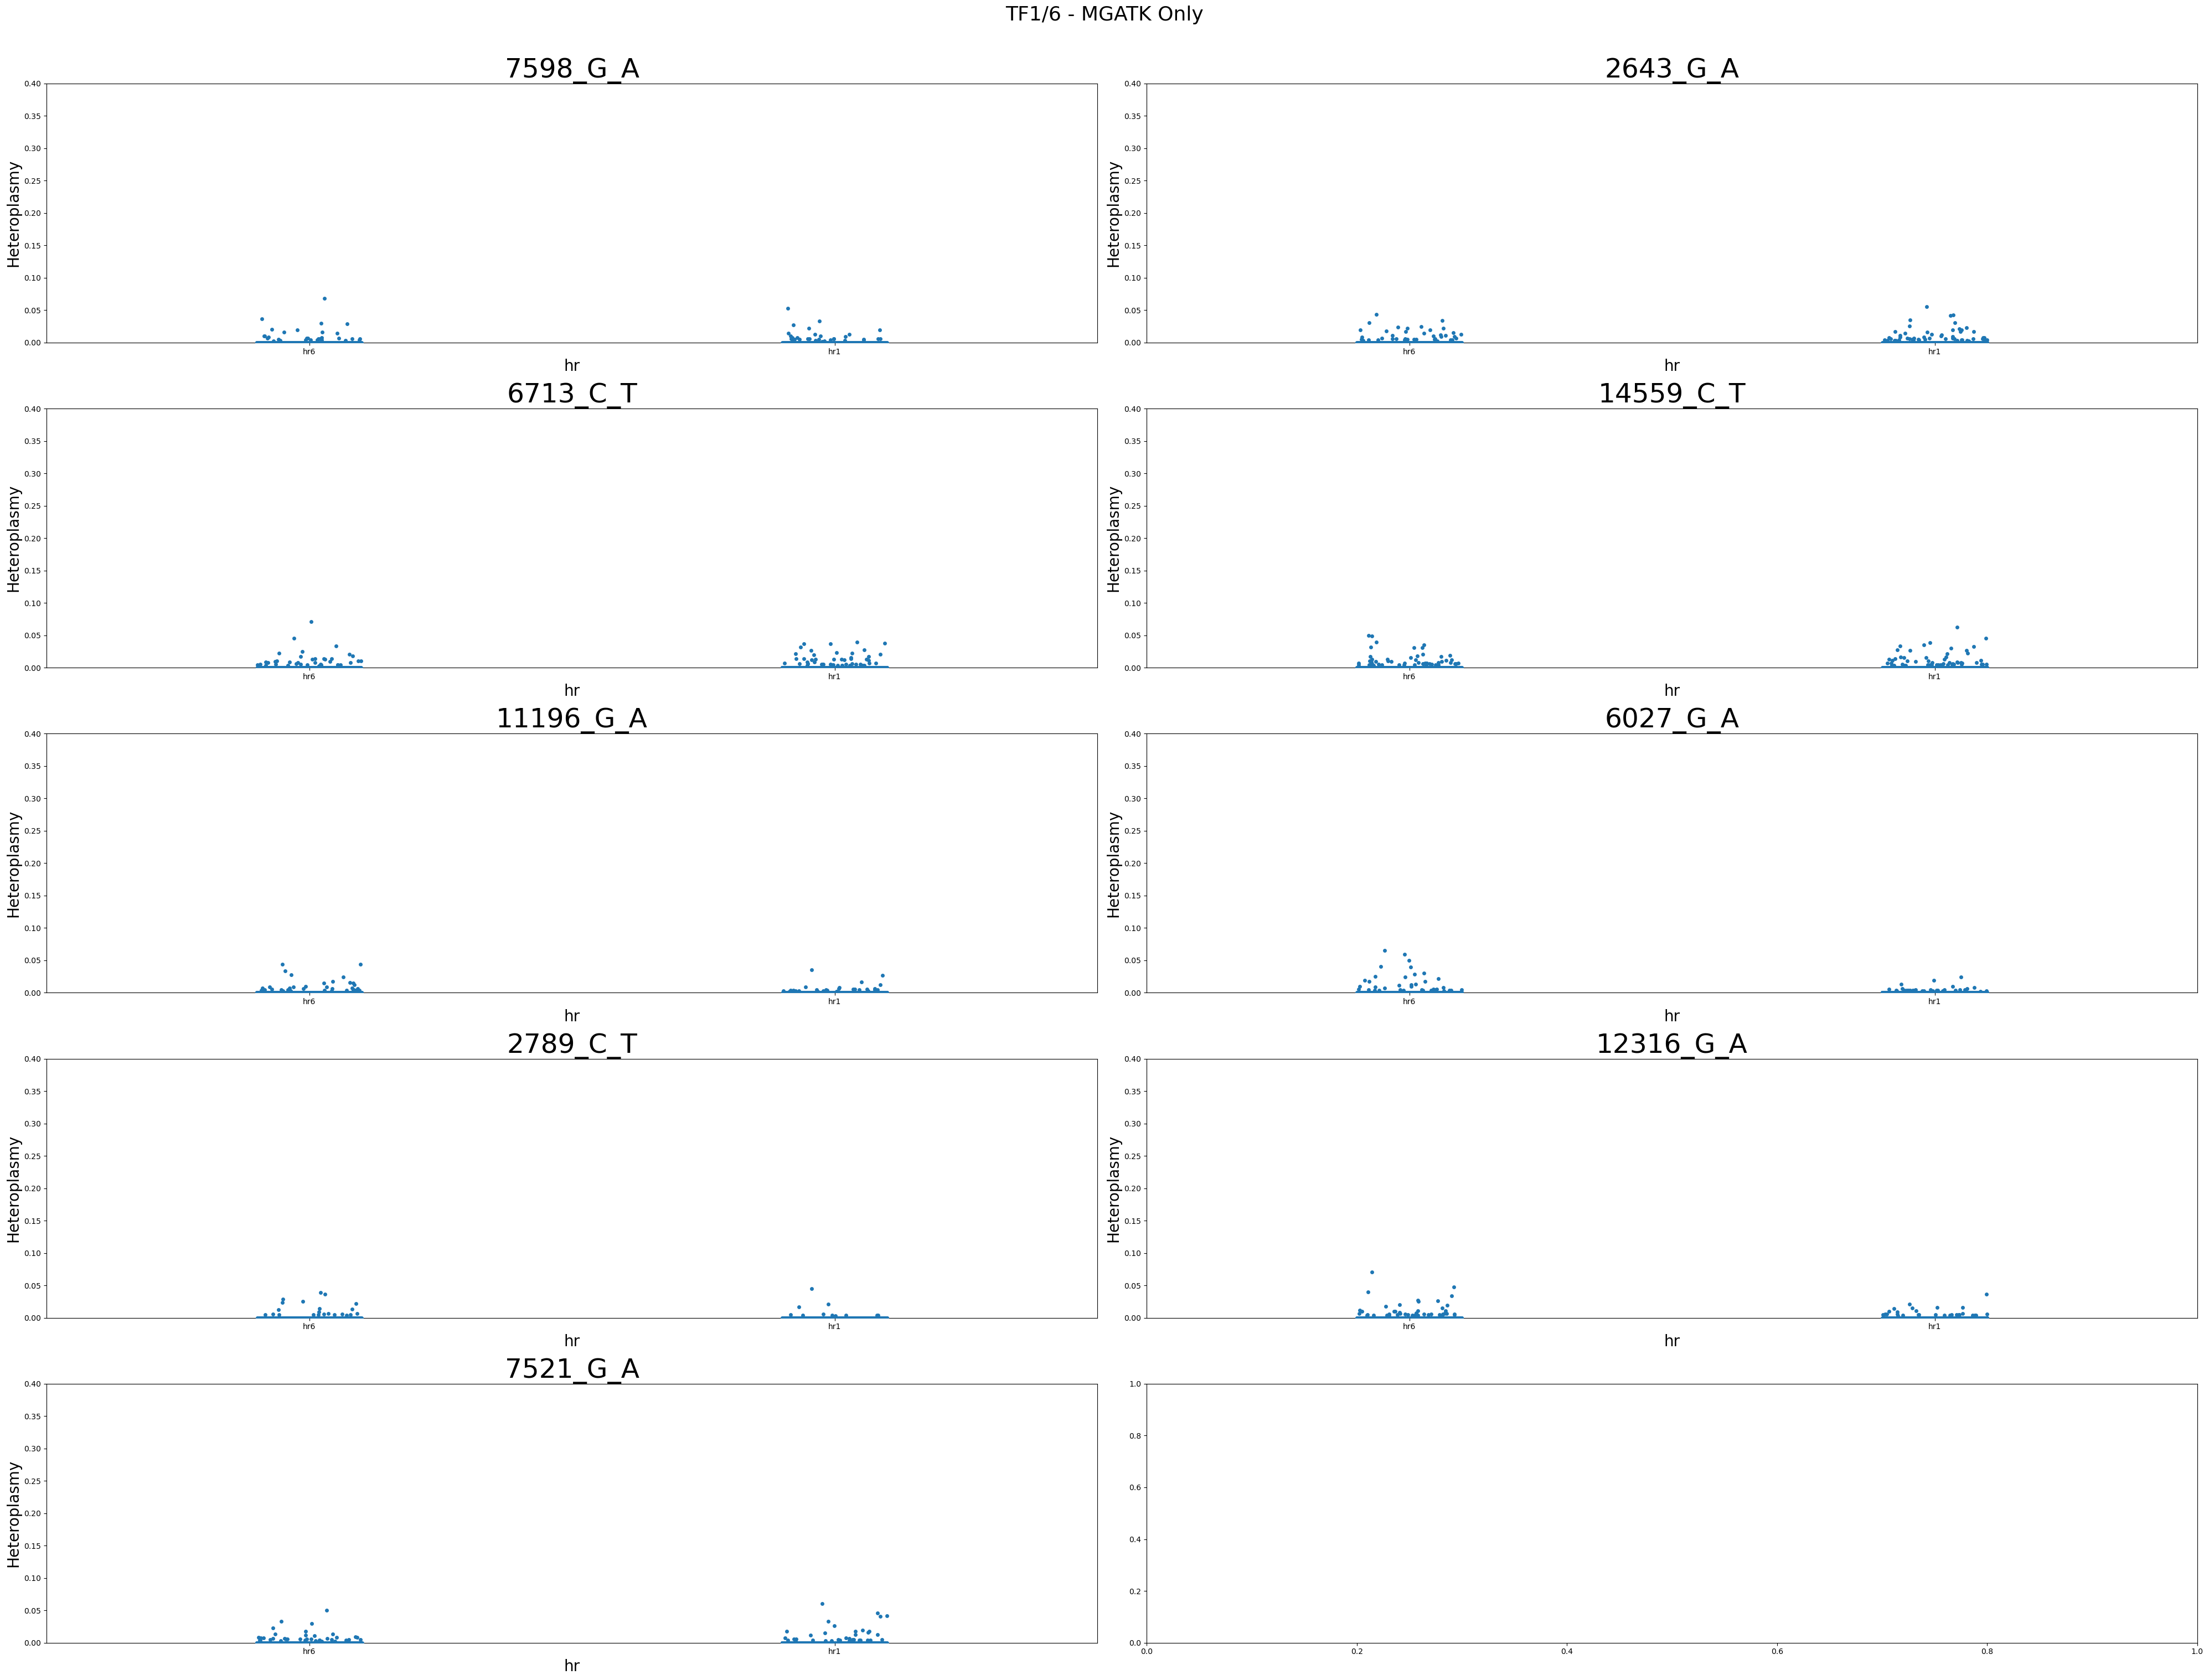

In [66]:
# MGATK only
melted['hr'] = melted['variable'].apply(lambda v: v.split("_")[1])

fig,ax = plt.subplots(5,2,figsize=(40,30))
for i,variant in enumerate(list(left)):
    
    variant_df = melted[melted['variant']==variant]
    _ax = ax.reshape(-1)[i]
    _ax.set_title(variant,fontsize=35)
    sns.stripplot(variant_df, x='hr',y='heteroplasmy',ax=_ax)
    _ax.set_xlabel('hr',fontsize=20)
    _ax.set_ylabel('Heteroplasmy',fontsize=20)
    _ax.set_ylim([0,.4])
#     _ax.set_xticklabels([])
    
fig.suptitle('TF1/6 - MGATK Only',fontsize=26,y=1.01)
fig.tight_layout()

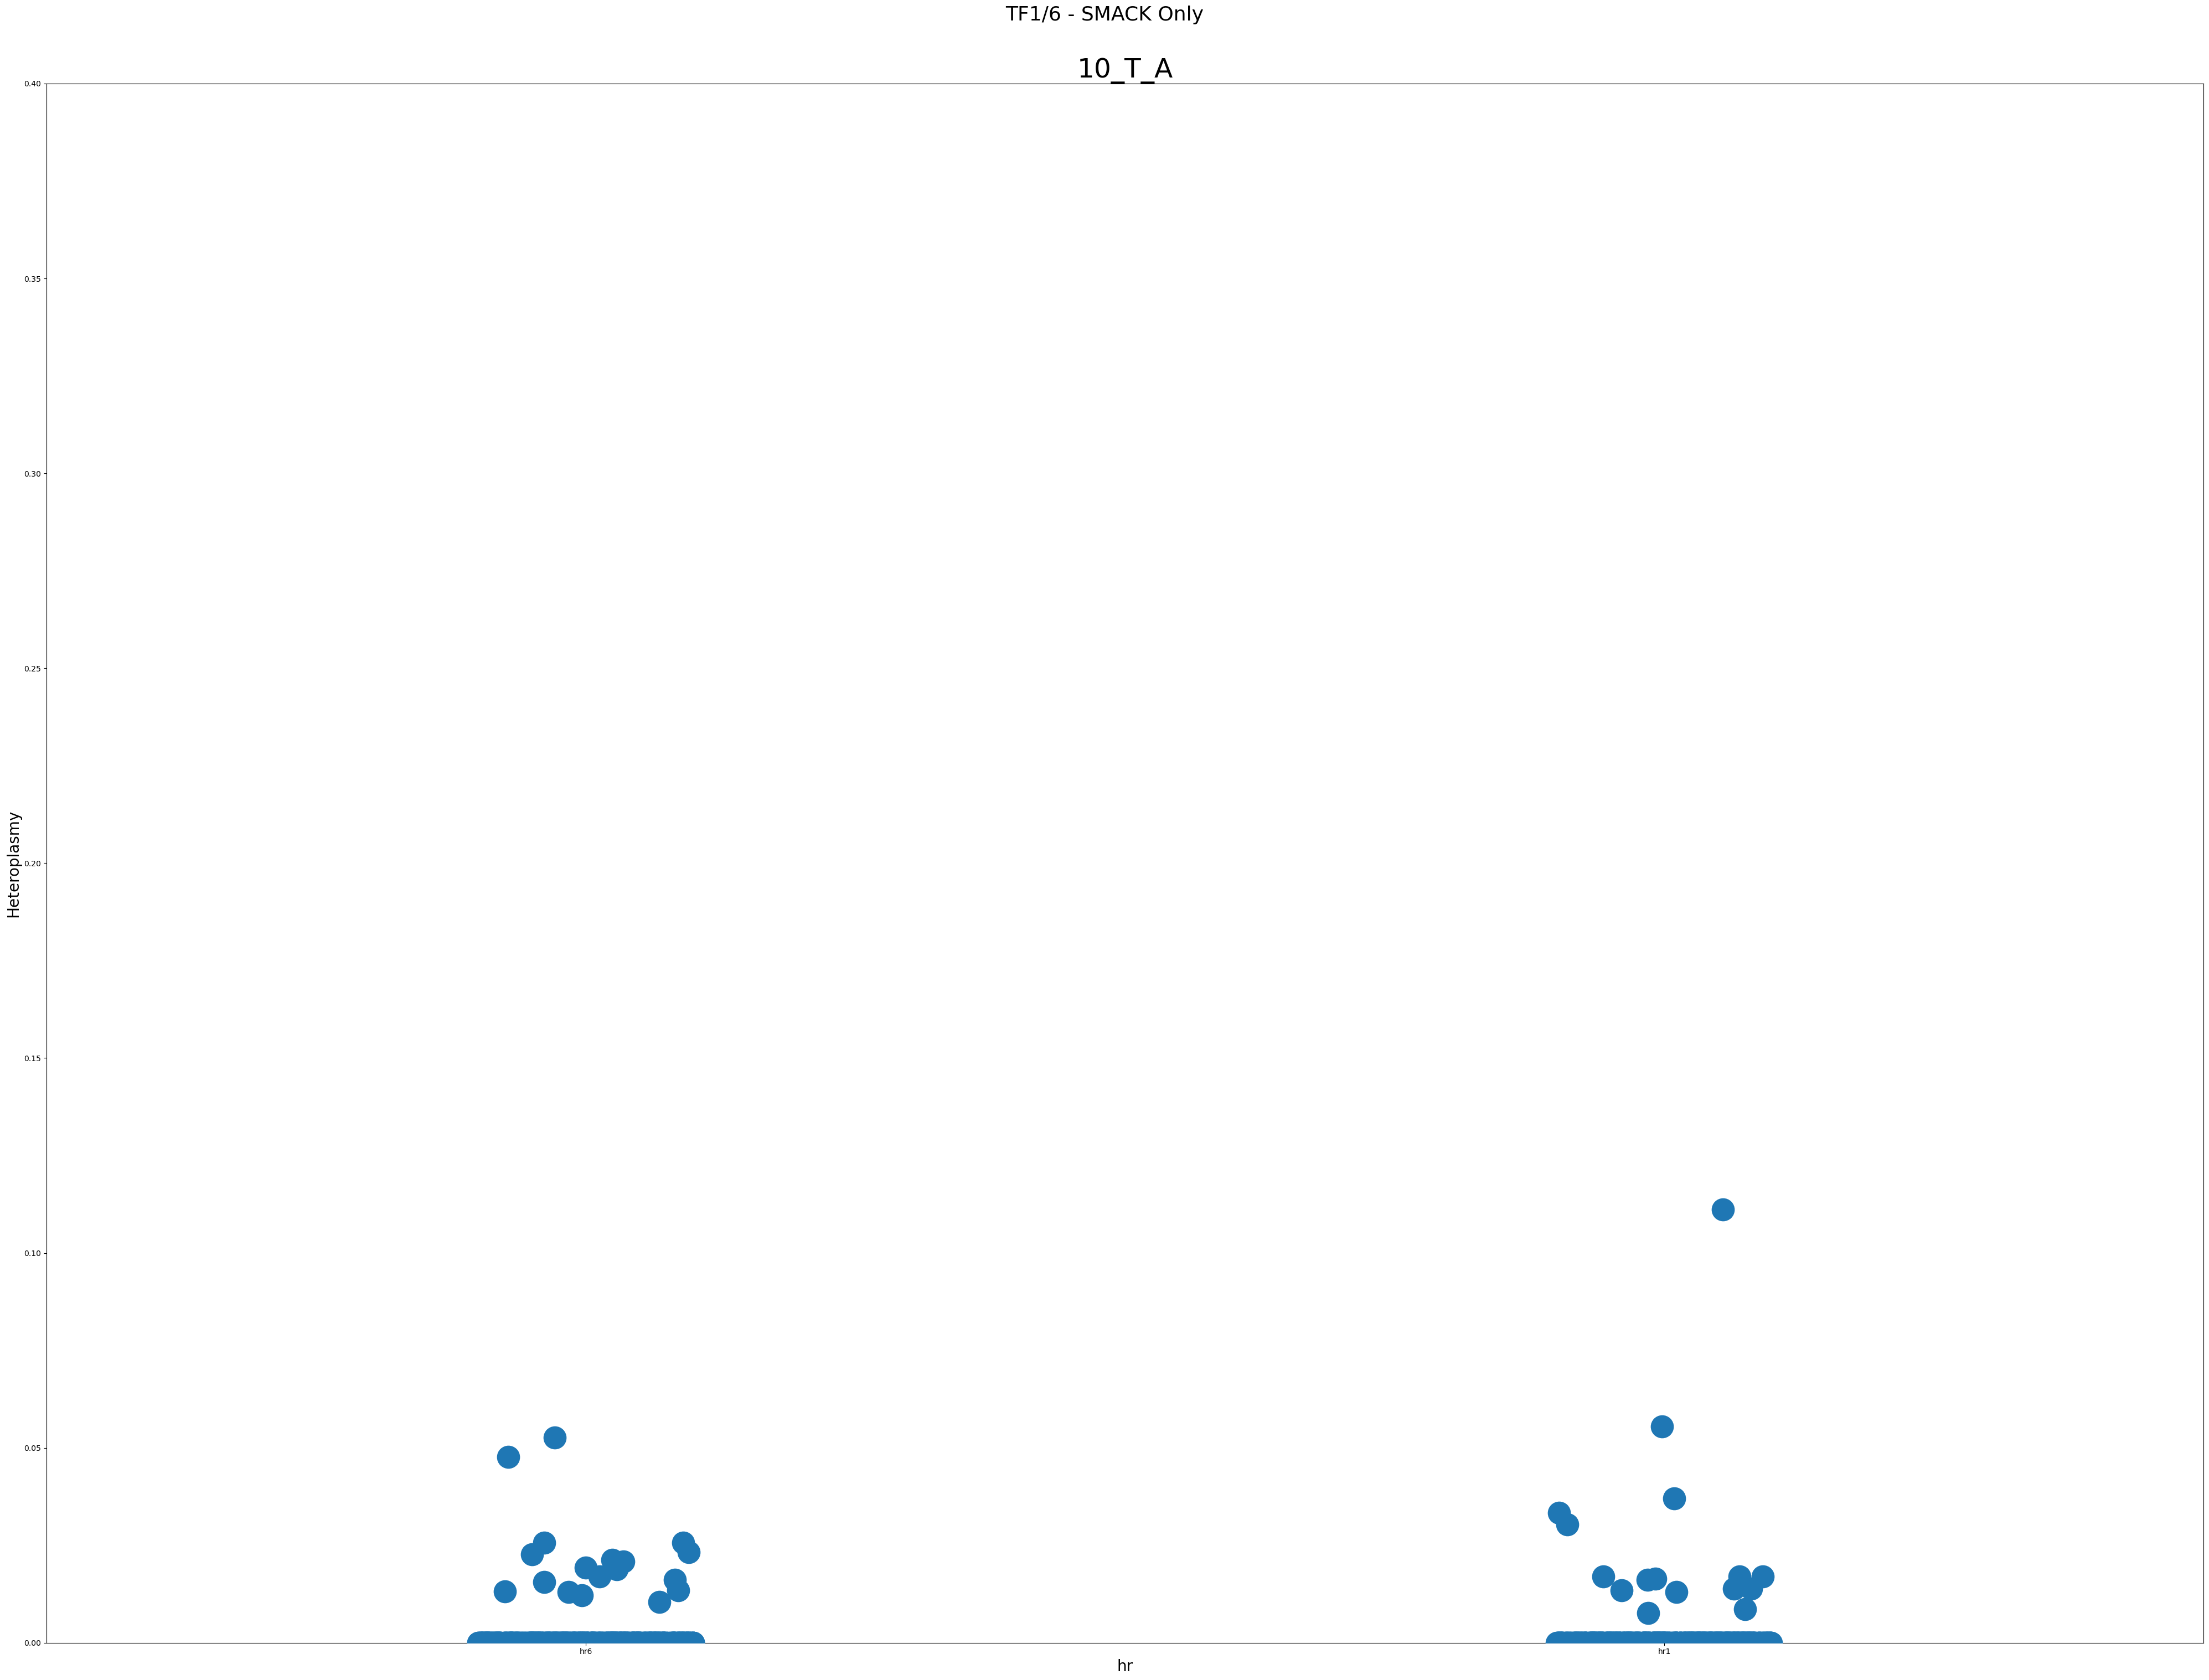

In [67]:
# SMACK only
melted = full_matrix.loc[list(right)].melt(value_name='heteroplasmy',id_vars='variant')
melted['hr'] = melted['variable'].apply(lambda v: v.split("_")[1])

fig,ax = plt.subplots(1,1,figsize=(40,30))
for i,variant in enumerate(list(right)):
    
    variant_df = melted[melted['variant']==variant]
    _ax = ax
    
    _ax.set_title(variant,fontsize=35)
    sns.stripplot(variant_df, x='hr',y='heteroplasmy',ax=_ax,size=30)
    _ax.set_xlabel('hr',fontsize=20)
    _ax.set_ylabel('Heteroplasmy',fontsize=20)
    _ax.set_ylim([0,.4])
#     _ax.set_xticklabels([])
    
fig.suptitle('TF1/6 - SMACK Only',fontsize=26,y=1.01)
fig.tight_layout()

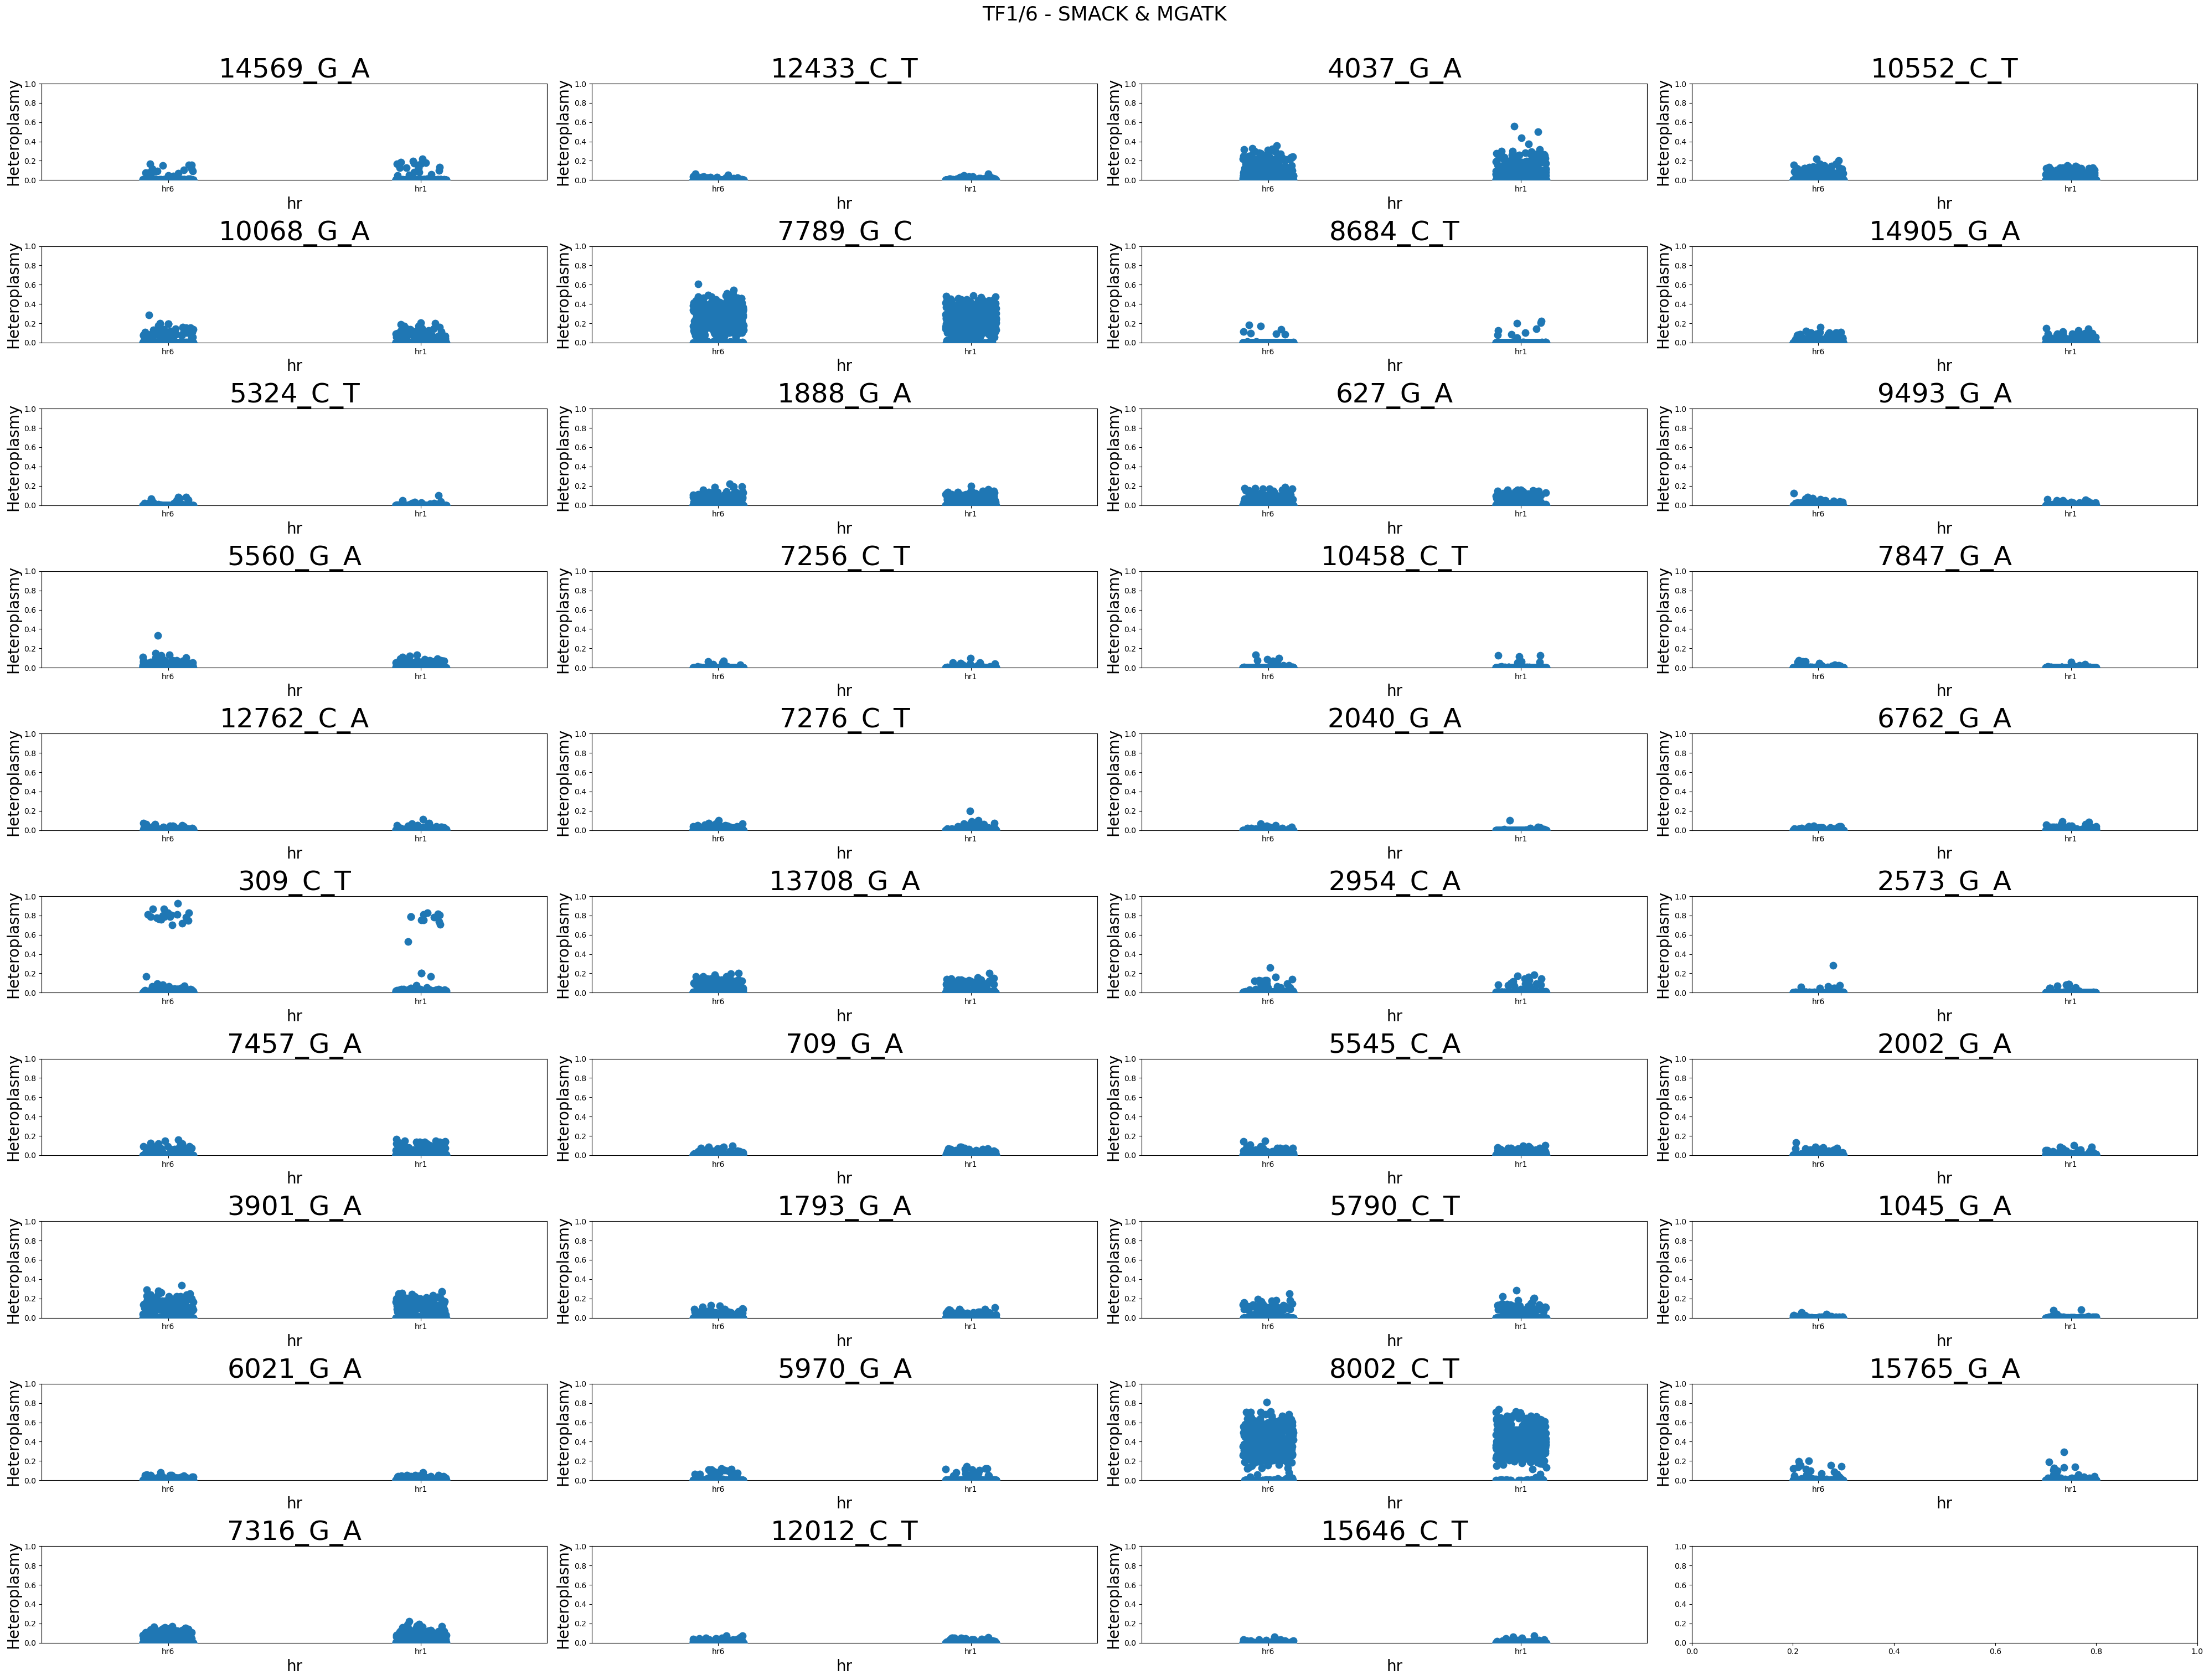

In [68]:
# SMACK and MGATK agree
melted = full_matrix.loc[list(center)].melt(value_name='heteroplasmy',id_vars='variant')
melted['hr'] = melted['variable'].apply(lambda v: v.split("_")[1])

fig,ax = plt.subplots(10,4,figsize=(40,30))
for i,variant in enumerate(list(center)):
    
    variant_df = melted[melted['variant']==variant]
    _ax = ax.reshape(-1)[i]
    
    _ax.set_title(variant,fontsize=35)
    sns.stripplot(variant_df, x='hr',y='heteroplasmy',ax=_ax,size=10)
    _ax.set_xlabel('hr',fontsize=20)
    _ax.set_ylabel('Heteroplasmy',fontsize=20)
    _ax.set_ylim([0,1])
#     _ax.set_xticklabels([])
    
fig.suptitle('TF1/6 - SMACK & MGATK',fontsize=26,y=1.01)
fig.tight_layout()

In [69]:
max_value = matrix.values.max()
min_value = 0
vals = np.linspace(min_value,max_value,20)
values = []


for val in vals:
    mat = matrix.values.copy()
    baseline = np.sum(mat>=0)
    values.append(np.sum(mat <= val)/baseline)    

Text(0, 0.5, 'fraction of entries <= threshold')

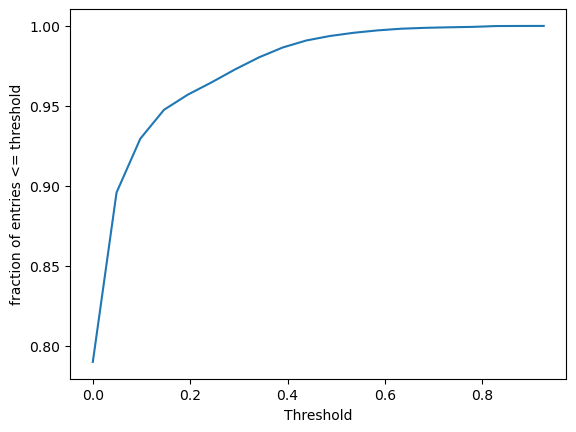

In [70]:
plt.plot(vals, values)
plt.xlabel('Threshold')
plt.ylabel('fraction of entries <= threshold')

<Axes: ylabel='Proportion'>

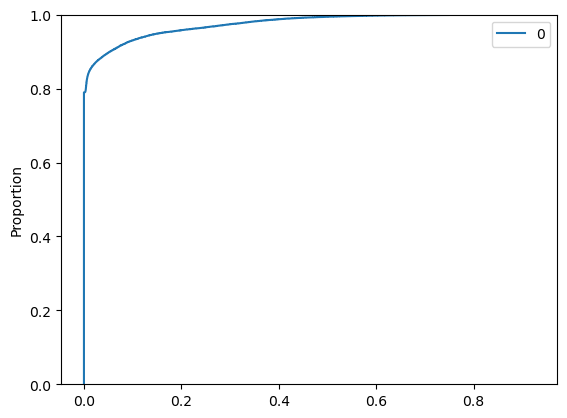

In [71]:
sns.ecdfplot(np.reshape(matrix.values,(matrix.values.shape[0]*matrix.values.shape[1],1)))